### Import libraries

In [0]:
import torch
from torchtext import data
from torchtext import datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (4, 4)

**Set random state**

In [0]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Data loading and preprocessing

In [0]:
TEXT = data.Field(tokenize = 'spacy', stop_words = 'spacy.lang.en.stop_words.STOP_WORDS')
LABEL = data.LabelField(dtype = torch.float)

In [4]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:03<00:00, 23.0MB/s]


In [5]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [6]:
print(vars(train_data.examples[0]))

{'text': ['Thankfully', 'as', 'student', 'I', 'have', 'been', 'able', 'watch', '"', 'Diagnosis', 'Murder', '"', 'for', 'number', 'of', 'years', 'now', 'It', 'is', 'basically', 'about', 'doctor', 'who', 'solves', 'murders', 'with', 'the', 'help', 'of', 'his', 'LAPD', 'son', ',', 'young', 'doctor', 'and', 'pathologist', 'DM', 'provided', '8', 'seasons', 'of', 'exceptional', 'entertainment', 'What', 'made', 'it', 'different', 'from', 'the', 'many', 'other', 'cop', 'shows', 'and', 'worth', 'watching', 'many', 'times', 'over', 'was', 'its', 'cast', 'and', 'quality', 'of', 'writing', 'The', 'main', 'cast', 'gave', 'good', 'performances', 'and', 'Dick', 'Van', 'Dyke', "'s", 'entertainer', 'roots', 'shone', 'through', 'with', 'the', 'use', 'of', 'magic', ',', 'dance', 'and', 'humor', 'The', 'best', 'aspects', 'of', 'DM', 'was', 'the', 'fast', 'pace', ',', 'witty', 'scripts', 'and', 'of', 'course', 'the', 'toe', 'tapping', 'score', 'Sadly', 'it', 'has', 'been', 'unfairly', 'compared', '"', 'Mur

**Build vocabulary**

In [0]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

In [8]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


Why 25002 instead of 25000:
<br> **unk** - for values, that is not in vocab 
<br> **pad** - padding; because data will be in bathes, all sentences have to be same size

In [14]:
print("20 most common words: ",TEXT.vocab.freqs.most_common(20), "\n\n", "Vacabulary labels: ", LABEL.vocab.stoi, sep = "")


20 most common words: [('the', 289836), (',', 275277), ('and', 156487), ('of', 144056), ('is', 109094), ('in', 87678), ('I', 77542), ('it', 76536), ('that', 70353), ('"', 63334), ("'s", 61909), ('this', 60474), ('-', 52864), ('/><br', 50935), ('was', 50012), ('as', 43510), ('with', 42807), ('movie', 42419), ('for', 42111), ('film', 38837)]

Vacabulary labels: defaultdict(<function _default_unk_index at 0x7fb23eec71e0>, {'neg': 0, 'pos': 1})


### Model preparation and train/test steps

**Batches iterator**

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

**Class for statistics agregation**

In [0]:
class Mean(object):
    def __init__(self):
        self.values = []

    def compute(self):
        return sum(self.values) / len(self.values)

    def update(self, value):
        self.values.extend(np.reshape(value, [-1]))

    def reset(self):
        self.values = []

    def compute_and_reset(self):
        value = self.compute()
        self.reset()

        return value

 **Baseline model**
<br>The embedding layer is used to transform sparse one-hot vector into a dense embedding vector. This embedding layer is a single fully connected layer. As well as reducing the dimensionality of the input to the RNN, there is the theory that words which have similar impact on the sentiment of the review are mapped close together in this dense vector space.
<br>The RNN returns 2 tensors, output of size [sentence length, batch size, hidden dim] and hidden of size [1, batch size, hidden dim]. Output is the concatenation of the hidden state from every time step, whereas hidden is simply the final hidden state.

In [0]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

**Accuracy mesuremnet**

In [0]:
def accuracy(a, b):
    return (a.float() == b.float()).float().mean()

**Train/test**

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
opt = torch.optim.Adam(model.parameters(), 1e-3)

model = model.cuda()

In [0]:
stats = {
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': []
}

train_accs = Mean()
train_losses = Mean()
test_accs = Mean()
test_losses = Mean()





  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, train loss 0.70, train acc 0.50, test loss 0.72, test acc 0.49


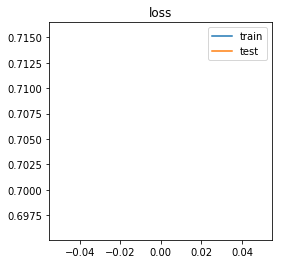

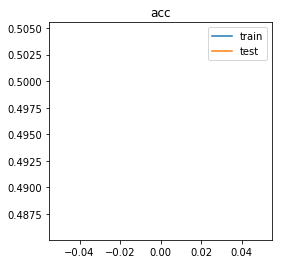





 20%|██        | 1/5 [01:26<05:45, 86.49s/it]

epoch 1, train loss 0.70, train acc 0.49, test loss 0.69, test acc 0.55


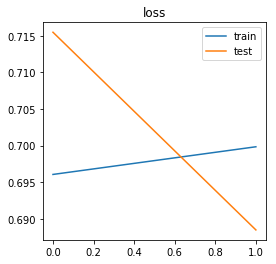

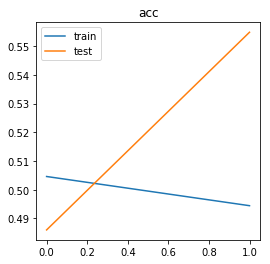





 40%|████      | 2/5 [02:55<04:21, 87.25s/it]

epoch 2, train loss 0.70, train acc 0.50, test loss 0.69, test acc 0.51


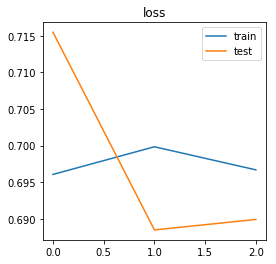

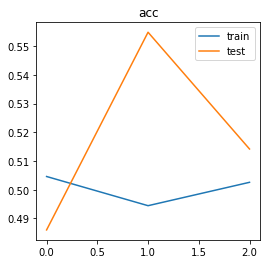





 60%|██████    | 3/5 [04:23<02:55, 87.56s/it]

epoch 3, train loss 0.70, train acc 0.50, test loss 0.68, test acc 0.62


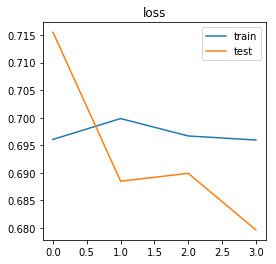

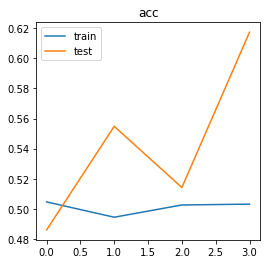





 80%|████████  | 4/5 [05:51<01:27, 87.60s/it]

epoch 4, train loss 0.70, train acc 0.50, test loss 0.68, test acc 0.55


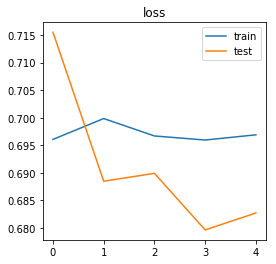

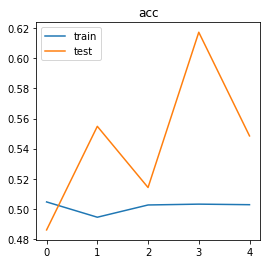





100%|██████████| 5/5 [07:19<00:00, 87.74s/it]





In [48]:
for epoch in tqdm(range(5)):
    model.train()
    for batch in train_iterator:
        
        logits = model(batch.text).squeeze(1)
        
        train_loss = F.binary_cross_entropy_with_logits(input=logits, target=batch.label)
        train_acc = accuracy(batch.label, logits > 0.)
        
        train_losses.update(train_loss.data.cpu().numpy())
        train_accs.update(train_acc.data.cpu().numpy())
        
        opt.zero_grad()
        train_loss.backward()
        opt.step()
        
    with torch.no_grad():
      model.eval()
      
      for batch in test_iterator:
        
        logits = model(batch.text).squeeze(1)
        
        test_loss = F.binary_cross_entropy_with_logits(input=logits, target=batch.label)
        test_acc = accuracy(batch.label, logits > 0.)
        
        test_losses.update(test_loss.data.cpu().numpy())
        test_accs.update(test_acc.data.cpu().numpy())
        
    train_loss = train_losses.compute_and_reset()
    train_acc = train_accs.compute_and_reset()
    test_loss = test_losses.compute_and_reset()
    test_acc = test_accs.compute_and_reset()
    
    print('epoch {}, train loss {:.2f}, train acc {:.2f}, test loss {:.2f}, test acc {:.2f}'.format(epoch, train_loss, train_acc, test_loss, test_acc))

    stats['train_loss'].append(train_loss)
    stats['train_acc'].append(train_acc)
    stats['test_loss'].append(test_loss)
    stats['test_acc'].append(test_acc)

    plt.plot(stats['train_loss'], label='train')
    plt.plot(stats['test_loss'], label='test')     
    plt.title('loss')
    plt.legend()
    plt.show()

    plt.plot(stats['train_acc'], label='train')
    plt.plot(stats['test_acc'], label='test')
    plt.title('acc')
    plt.legend()
    plt.show()